In [17]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR

from libs.datasets import CDSDataset, JHUDataset
from libs.datasets import DHBeds, FIPSPopulation
from libs.datasets.dataset_utils import AggregationLevel
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# import matplotlib and related libraries
%matplotlib inline
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [20]:
timeseries_data = JHUDataset.local().timeseries()
beds_data = DHBeds.local().beds()
population_data = FIPSPopulation.local().population()

In [21]:
def model_state(country, state, interventions=None):
   
    # we should cut this, only used by the get_timeseries function, but probably not needed
    MODEL_INTERVAL = 4

    # Pack all of the assumptions and parameters into a dict that can be passed into the model    
    DATA_PARAMETERS = {
        'timeseries': timeseries_data.get_subset(AggregationLevel.STATE).get_data(country=country, state=state),
        'beds': beds_data.get_state_level(state),
        'population': population_data.get_state_level(country, state)
    }
    
    MODEL_PARAMETERS = {        
        'model': 'seir',
#         'model': 'asymp',
        'model_cols': ["total", "susceptible", "exposed", "infected", "infected_a", "infected_b", "infected_c", "recovered", "dead",],
#         'model_cols': ["total", "susceptible", "exposed", "infected", "asymp", "infected_a", "infected_b", "infected_c", "recovered", "dead",],
        
        'use_harvard_params': False, #If True use the harvard parameters directly, if not calculate off the above
        'fix_r0': False, #If True use the parameters that make R0 2.4, if not calculate off the above
        
        'days_to_model': 270,

        ## Variables for calculating model parameters Hill -> our names/calcs    
        # IncubPeriod: Average incubation period, days - presymptomatic_period
        # DurMildInf: Average duration of mild infections, days - duration_mild_infections
        # FracMild: Average fraction of (symptomatic) infections that are mild - (1 - hospitalization_rate)
        # FracSevere: Average fraction of (symptomatic) infections that are severe - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # FracCritical: Average fraction of (symptomatic) infections that are critical - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # CFR: Case fatality rate (fraction of infections that eventually result in death) - case_fatality_rate
        # DurHosp: Average duration of hospitalization (time to recovery) for individuals with severe infection, days - hospital_time_recovery
        # TimeICUDeath: Average duration of ICU admission (until death or recovery), days - icu_time_death 
        
        # LOGIC ON INITIAL CONDITIONS:
        # hospitalized = case load from timeseries on last day of data / 4
        # mild = hospitalized / hospitalization_rate
        # icu = hospitalized * hospitalized_cases_requiring_icu_care
        # expoosed = exposed_infected_ratio * mild
        
        'presymptomatic_period': 3, # Time before exposed are infectious, In days
        'duration_mild_infections': 6, # Time mildly infected people stay sick before hospitalization or recovery, In days
        'hospital_time_recovery': 6, #Duration of hospitalization before icu or recovery, In days
        'icu_time_death': 8, #Time from ICU admission to death, In days

        'beta': 0.6,
        'beta_hospitalized': 0.1,
        'beta_icu': 0.1,

        "hospitalization_rate": 0.0727,
        "hospitalized_cases_requiring_icu_care": 0.1397,
        "case_fatality_rate": 0.0109341104294479,
        
        'exposed_from_infected': True,

        'asymp_to_mild_ratio': 1,
        
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,     

        'interventions': interventions,
        'observed_daily_growth_rate': 1.21,
    }
    
    MODEL_PARAMETERS['beta'] = (0.3 + ( (MODEL_PARAMETERS["observed_daily_growth_rate"] - 1.09) / 0.02) * 0.05)
    
    MODEL_PARAMETERS['case_fatality_rate_hospitals_overwhelmed'] = MODEL_PARAMETERS['hospitalization_rate'] * MODEL_PARAMETERS['hospitalized_cases_requiring_icu_care']
    
    MODEL_PARAMETERS['exposed_infected_ratio'] = 1
    
    MODEL_PARAMETERS.update(DATA_PARAMETERS)
    
    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)

INTERVENTIONS = [{
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 4, 20): 1.1,
        datetime.date(2020, 5, 22): 0.8,
        datetime.date(2020, 6, 23): None
    }]

In [22]:
#timeseries_data.get_subset(AggregationLevel.STATE).get_data('USA', 'TX', 1) #[['date','cases','deaths','recovered','active']]
#beds_data.get_state_level('NY')

In [23]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]

    x_dates = df['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
        
    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))

    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    #df_plt.set_xticklabels(labels=x_dates, rotation=45, ha='right')

    return(df_plt)

In [24]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

In [25]:
df.iloc[25:].head(25)

,date,dead,exposed,infected,infected_a,infected_b,infected_c,recovered,total,infected_tmp,susceptible,pct_change,doubling_time,beds
25,2020-03-09,0.00,0.00,14.00,14.00,0.00,0.00,0.00,28995881.00,0.00,28995853.00,nan,nan,73791
26,2020-03-10,0.00,0.00,13.00,13.00,0.00,0.00,0.00,28995881.00,0.00,28995855.00,nan,nan,73791
27,2020-03-11,0.00,0.00,21.00,21.00,0.00,0.00,0.00,28995881.00,0.00,28995839.00,nan,nan,73791
28,2020-03-12,0.00,0.00,27.00,27.00,0.00,0.00,0.00,28995881.00,0.00,28995827.00,nan,nan,73791
29,2020-03-13,0.00,0.00,43.00,43.00,0.00,0.00,0.00,28995881.00,0.00,28995795.00,nan,nan,73791
30,2020-03-14,0.00,0.00,57.00,57.00,0.00,0.00,0.00,28995881.00,0.00,28995767.00,nan,nan,73791
31,2020-03-15,0.00,0.00,72.00,72.00,0.00,0.00,0.00,28995881.00,0.00,28995737.00,nan,nan,73791
32,2020-03-16,0.00,0.00,85.00,85.00,0.00,0.00,0.00,28995881.00,0.00,28995711.00,nan,nan,73791
33,2020-03-17,1.00,0.00,109.00,109.00,0.00,0.00,0.00,28995881.00,0.00,28995662.00,nan,nan,73791
34,2020-03-18,3.00,0.00,170.00,170.00,0.00,0.00,0.00,28995881.00,0.00,28995538.00,nan,nan,73791


avg doubling time by week
      doubling_time
week               
1             -5.72
2             -5.74
3             -5.75
4             -5.76
5             -5.78
6             -5.79
7             -5.80
8             -5.82
9             -5.83
10            -5.84
11            -5.86
12            -5.88
13            -5.81
14             7.63
15             6.71
16             7.73
17          -156.28
18            11.97
19            23.83
20            36.35
21          -263.74
22            32.65
23           -74.22
24           -25.45
25           -26.78
26         -2764.74
27             3.82
28             3.30
29             3.76
30             6.00
31            48.55
32           -39.03
33           -10.62
34            -7.93
35            -6.92
36            -6.42
37            -6.14
38            -5.97
39            -5.85
40            -5.78
41            -5.73
42            -5.69
43            -5.67
44            -5.66
45            -5.65
46            -5.65
47            

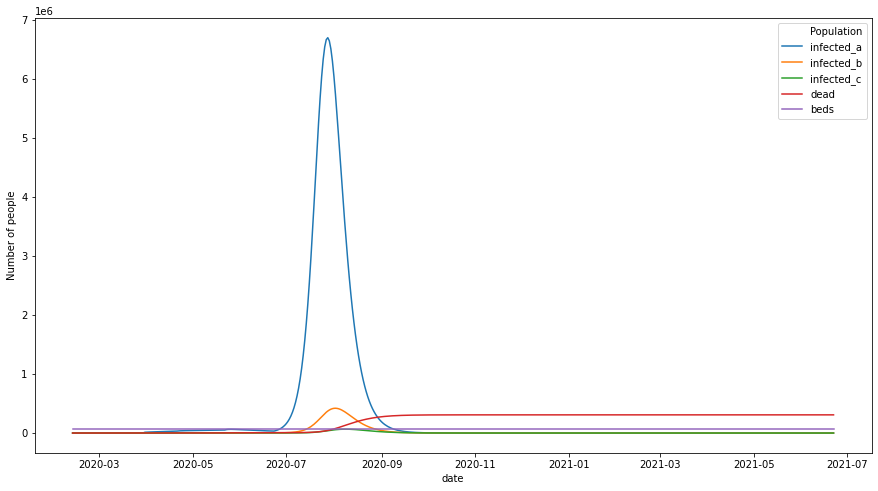

In [26]:
df['week'] = pd.DatetimeIndex(df['date']).week
avg_doubling_month = df.loc[:, ('week', 'doubling_time')].groupby('week').mean()

print('avg doubling time by week')
print(avg_doubling_month)

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(df, chart_cols)

In [27]:
use_harvard_init = False #If True use the harvard model inputs for inital conditions and N (recreate their graph)
#use_harvard_init = True #If True use the harvard model inputs for inital conditions and N (recreate their graph)

In [28]:
# [df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

# print(df.iloc[-1])
# #print(initervention_df.iloc[-20])

# df['month'] = pd.DatetimeIndex(df['date']).month
# avg_doubling_month = df.loc[:, ('month', 'doubling_time')].groupby('month').mean()
# print(chart_cols)
# plot_df(df, chart_cols)

In [29]:
# df.head(25)

In [30]:
# [intervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[3])

In [31]:
# first_case_date = intervention_df.loc[(intervention_df.infected > 0), 'date'].min()
# peak_date = intervention_df.loc[(intervention_df.infected_b == intervention_df.infected_b.max())]['date'].values[0]

# #chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
# chart_cols = ["infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
# #chart_cols = ["infected", "infected_b", "infected_c",  "dead"] #, "susceptible"]
# plot_df(df, chart_cols)

In [32]:
# if use_harvard_init:
#     tmax=365
#     N = 1000
#     tvec=np.arange(0,tmax,0.1)
# else:
#     # tmax = 80 * 4
#     tmax = 365
#     N =  28995881.00
#     #N = 10000
#     tvec=np.arange(0,tmax,1)
    
# #print(np.array(N-np.sum(soln,axis=1,keepdims=True)))
# #s = [N-np.sum(soln,axis=1,keepdims=True)]
# #s = np.max(s,0)
# soln_plt = np.hstack([soln])
# #soln_plt = np.hstack(soln)

# print('avg doubling time by month')
# print(avg_doubling_month)

# intervention_df['week'] = pd.DatetimeIndex(intervention_df['date']).week
# avg_doubling_month = intervention_df.loc[:, ('week', 'doubling_time')].groupby('week').mean()

# print('avg doubling time by week')
# print(avg_doubling_month)

# #chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
# chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

# plot_df(intervention_df, chart_cols)